<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230702_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [4]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

In [5]:
main_figsize=(15,3)

In [6]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):

    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""

        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        #self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, self.input_dim*10))
            #self.fc2.append(nn.BatchNorm1d(num_features=50))
            self.fc3.append(nn.Linear(self.input_dim*10, 1))

        #self.fc = nn.Linear(input_dim, input_dim)

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = F.relu(self.fc2[i](h0))
            #h2 = self.fc3[i](h1)
            h2 = self.fc3[i](F.relu(h0))
            pxy.append(h2)

        #return self.fc(torch.tensor(torch.cat(pxy, dim=1), requires_grad = True))
        return torch.cat(pxy, dim=1)


In [115]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).

    This class is for defining the structure of FR-Train generator (classifier).
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """

    def __init__(self, input_dim=5):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


In [121]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score

def test_model(model_,model2_, tX, ty, avaible_range,columns):
    model_.eval()

    b_dim = tX.shape[1]-1

    if model2_ == None:
        ax = tX[:,0:b_dim]
    else:
        model2_.eval()
        ax = model2_(tX[:,0:b_dim],tX[:,b_dim].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    ty_ = ty.cpu().data.numpy()
    f1 = f1_score(ty_,y_hat)
    #################### MI #########################
    ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
    haf_size = int(ax_df.shape[0]/2)

    mi_scores = make_mi_scores(ax_df, y_hat, discrete_features="auto")
    sum_mi = np.sum(mi_scores)
    std_mi = np.std(mi_scores)

    mi_scores = make_mi_scores(ax_df[0:haf_size], y_hat[0:haf_size], discrete_features="auto")
    asum_mi = np.sum(mi_scores)
    astd_mi = np.std(mi_scores)

    mi_scores = make_mi_scores(ax_df[-haf_size:], y_hat[-haf_size:], discrete_features="auto")
    bsum_mi = np.sum(mi_scores)
    bstd_mi = np.std(mi_scores)

    print("Test f1 score: {}".format(f1))
    '''
    print("Sum of MI = {:.5f}".format(sum_mi))
    print("Std of MI = {:.5f}".format(std_mi))
    print("Sum of MI A = {:.5f}".format(asum_mi))
    print("Std of MI A = {:.5f}".format(astd_mi))
    print("Sum of MI B = {:.5f}".format(bsum_mi))
    print("Std of MI B = {:.5f}".format(bstd_mi))
    print("ABS(sum(A-B)) = {:.5f}".format(np.abs(asum_mi-bsum_mi)))
    print("ABS(std(A-B)) = {:.5f}".format(np.abs(astd_mi-bstd_mi)))
    '''
    return f1, (sum_mi,std_mi,asum_mi,astd_mi,bsum_mi,bstd_mi,np.abs(asum_mi-bsum_mi),np.abs(astd_mi-bstd_mi))

In [129]:

def test_all_data(generator,adapter,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)
    b_dim = X_live.shape[1]-1
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        if adapter == None:
            xs = X_live_unit[:,0:b_dim]
        else:
            xs = adapter(X_live_unit[:,0:b_dim],X_live_unit[:,b_dim].reshape(-1,1)/avaible_range)
        predicted_y = generator(xs)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = xs.cpu().data.numpy()
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({train_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({train_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({train_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

    print(f'mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [10]:
H=20

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y.reshape(-1,1)))
            h1 = self.fc3[i](h0)
            h.append(h1)

        return torch.cat(h, dim=1)

class customLoss(nn.Module):
    def __init__(self, model):
        super(customLoss, self).__init__()
        self.model = model

    def forward(self, x,y):
        minibatch = int(x.shape[0] * 0.8)
        s = np.random.choice(x.shape[0],minibatch)
        #x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
        #y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        #y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)
        x_sample = x[s,:] #Variable(x[s,:], requires_grad = True)
        y_sample = y[s] #Variable(, requires_grad = True)
        y_shuffle = y[torch.randperm(minibatch)] #Variable(, requires_grad = True)
        p_xy = self.model(x_sample, y_sample)
        p_x_y = self.model(x_sample, y_shuffle)
        ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        loss = - ret
        return loss

In [122]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, columns,ShowChart = False, do_mine=True):
    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    b_dim = XS_train.shape[1]-1

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss(reduce=False)  # mean square error

    # Initializes generator and discriminator
    generator = Generator(b_dim).to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]


    adapter = Sensitivity_Adapter(b_dim).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net(b_dim).to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.01)
    loss_mse = customLoss(mine)



    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range) # z0, b
            ml = torch.mean(mse_loss(xs, XS_train[:,0:b_dim]),dim=0)
            a_loss =  torch.sum(ml) + torch.std(ml)
        else:
            xs = XS_train[:,0:b_dim]
            a_loss = torch.tensor(0.0)

        a_losses.append(a_loss.cpu().data.numpy())
        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)

        if do_mine and lambda_f >= 0.0:
            # -------------------
            #  Forwards MINE
            # -------------------
            mine_loss = loss_mse(xs,y_train)
        else:
            mine_loss = torch.tensor(0.0)

        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) + mine_loss.mean()
        g_losses.append(g_loss.cpu().data.numpy())




        optimizer_A.zero_grad()
        optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        if lambda_f >= 0.0:
            loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()
        optimizer_A.step()
        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, avaible_range,columns)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Adapter loss':a_losses,'Classifier loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({XS_train.shape[0]})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    plt.figure(figsize=main_figsize)
    plt.plot(a_losses,linewidth=1,label='Adapter loss')
    plt.plot(g_losses,linewidth=1,label='classifier loss')
    plt.ylabel('loss')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=2)
    plt.show()
    '''
    return f1,mi,generator,adapter,df_loss

In [12]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [13]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [14]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    columns = X.columns
    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis.values,linewidth=1,label=columns)
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf.values,linewidth=1,label=columns)
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    return X,Y

In [15]:
import copy
import torch.optim as optim

def train_classificaion_model(X,Y,train_size, test_size):
    seed_everything()

    mi_scores = make_mi_scores(X[test_size:test_size+train_size], Y[test_size:test_size+train_size], discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Convert to 2D PyTorch tensors
    X_train = torch.tensor(X[:train_size].values, dtype=torch.float32).to(device)
    y_train = torch.tensor(Y[:train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    X_test = torch.tensor(X[test_size:test_size+train_size].values, dtype=torch.float32).to(device)
    y_test = torch.tensor(Y[test_size:test_size+train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    in_dim = X_train.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, in_dim),
        nn.ReLU(),
        nn.Linear(in_dim, 1),
        nn.Sigmoid()
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.BCELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 1000   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    plt.plot(history)
    plt.show()

    from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
    predicted_y = model(X_test)
    f1_ = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
    print(f'F1 Score:{f1_:.5f}')

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set), dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []

    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        predicted_y = model(X_live_unit)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        f1s.append(f1_)

    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({train_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

    result_table3 = {}
    #result_table3['lambda']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]
    result_table3['SUM(MI)']=[]

    #result_table3['lambda'].append('Case #1 Feature 5')
    result_table3['test_f1'].append(f1_)
    result_table3['init_f1'].append(f1s[0])
    result_table3['mean_f1'].append(np.mean(f1s))
    result_table3['last_f1'].append(f1s[-1])
    result_table3['SUM(MI)'].append(np.sum(mi_scores))

    result = pd.DataFrame(result_table3)
    print(result)
    return model, result

In [126]:
def drift_tolerant(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0):

    columns = X.columns[:-1]
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
    lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] #[-0.1,0.0,0.5] #
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['sum mi']=[]
    result_table2['std mi']=[]
    result_table2['sum * std']=[]
    result_table2['sum 1/2']=[]
    result_table2['std 1/2']=[]
    result_table2['sum 2/2']=[]
    result_table2['std 2/2']=[]
    result_table2['sum 1-2']=[]
    result_table2['std 1-2']=[]
    result_table2['sum 1+2']=[]
    result_table2['std 1+2']=[]
    infos = {}
    for lambda_f in lambda_f_set:
        print(f'######################### Lambda {lambda_f} ###########################')
        f1,mi,last_generator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2,columns = columns)# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_generator,last_adapter,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #1, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['sum mi'].append(mi[0])
        result_table2['std mi'].append(mi[1])
        result_table2['sum * std'].append(mi[0]*mi[1])
        result_table2['sum 1/2'].append(mi[2])
        result_table2['std 1/2'].append(mi[3])
        result_table2['sum 2/2'].append(mi[4])
        result_table2['std 2/2'].append(mi[5])
        result_table2['sum 1-2'].append(mi[6])
        result_table2['std 1-2'].append(mi[7])
        result_table2['sum 1+2'].append(mi[2]+mi[4])
        result_table2['std 1+2'].append(mi[3]+mi[5])

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df[1:]['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    best_lambda = result4_df[result4_df['sum * std']== np.min(result4_df[1:]['sum * std'])]['lambda']
    result_df[['Normal model',f'λ_{best_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    return result4_df

# 실험
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

### Dataset 준비

In [ ]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [ ]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [ ]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### 실험

In [ ]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
Y = y

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X, Y,train_size, test_size)
model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mine = Net(X1.shape[1]).to(device)
optimizer = torch.optim.Adam(mine.parameters(), lr=0.01)
loss_mse = customLoss(mine)
plot_loss = []

x = torch.tensor(X1.values,dtype=torch.float32).to(device)
y = torch.tensor(Y1,dtype=torch.float32).to(device)

for epoch in tqdm(range(300)):
    mine.zero_grad()
    mine_loss = loss_mse(x,y)
    mine_loss.mean().backward()
    optimizer.step()
    plot_loss.append(-mine_loss.cpu().data.numpy())


plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=X1.columns)

In [ ]:
df_loss.plot()

In [ ]:
X1['b'] = [int(b) for b in X1.index.values/100]
X1

In [ ]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

### Dataset 준비

In [ ]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [ ]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [ ]:
x1.shape

In [ ]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

plt.plot(y1_array,'.')

In [ ]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

### 실험

In [ ]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)
model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [ ]:
X1['b'] = [int(b/100) for b in X1.index.values]
X1

In [ ]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## synthetic data의 생성 (Case #3 MI의 증감(상대적), Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

### Dataset 준비

In [ ]:
import matplotlib.pyplot as plt

seed_everything(2)

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0+10*ii/40000, 5*cor_const * ii)
    e1 = 0.0 #np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)

plt.plot(y2_array,'.')

In [ ]:
m = 5 #np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

### 실험

In [ ]:
columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X2, y2,train_size, test_size)

In [ ]:
X1['b'] = [int(b/100) for b in X1.index.values]
X1

In [ ]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## synthetic data의 생성 (Case #4 MI의 고정, Drift의 증가)

### Dataset 준비

In [ ]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


### 실험

In [ ]:
columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X3, y3,train_size, test_size)

In [ ]:
X1['b'] = [int(b/100) for b in X1.index.values]
X1

In [ ]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## synthetic data의 생성 (Case #5 - Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우)

### Dataset 준비

In [ ]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


### 실험

In [ ]:
columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X4, y4,train_size, test_size)

In [ ]:
X1['b'] = [int(b/100) for b in X1.index.values]
X1

In [ ]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## real-world data 의 실험

### Loan data 실험

#### Dataset 준비

##### Data load

In [99]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [100]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


##### Data 정제

In [101]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,loan_paid
0,68407277,3600.0,36 months,13.99,C,C4,MORTGAGE,55000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
1,68355089,24700.0,36 months,11.99,C,C1,MORTGAGE,65000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2,68341763,20000.0,60 months,10.78,B,B4,MORTGAGE,63000.0,Not Verified,Dec-2015,...,Joint App,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
4,68476807,10400.0,60 months,22.45,F,F1,MORTGAGE,104433.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
5,68426831,11950.0,36 months,13.44,C,C3,RENT,34000.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,18000.0,60 months,9.49,B,B2,OWN,130000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260690,88948836,29400.0,60 months,13.99,C,C3,MORTGAGE,180792.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260691,89996426,32000.0,60 months,14.49,C,C4,MORTGAGE,157000.0,Source Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,0
2260692,90006534,16000.0,60 months,12.79,C,C1,RENT,150000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,3.0,0.0,N,Cash,N,1


In [102]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

##### Dataset 만들기

In [103]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [104]:

X[2010].shape

(11497, 81)

In [105]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [106]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries              0.375194
last_fico_range_high    0.092181
last_pymnt_amnt         0.085660
total_rec_late_fee      0.028345
int_rate                0.017441
                          ...   
revol_bal               0.000000
E5                      0.000000
F5                      0.000000
C2                      0.000000
total_acc               0.000000
Name: MI Scores, Length: 81, dtype: float64


In [107]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

+ 일부러 예측 확률을 떨어뜨리기 위해 (조정), "recoveries" feature를 제외 한다.

In [108]:
top_columns = list(mi_scores[1:10].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term',
 'Y',
 'total_rec_int',
 'RENT',
 'G4']

In [109]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2, 1, 80, 13, 78, 56]

In [110]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]
#X2_df_t5 = X2_df[top_columns]

#### 실험

MI Analysis MI Max 0.31588, Min 0.00109, Mean 0.10149, Std 0.10695
Dataset structure X_train, (10000, 9) X_test, (10000, 9) X_live (1278183, 9)
Truncate 28665 rows from live_set (1278183, 9)
Search MI & Drift...for X_live_set (848, 10000, 9)


100%|██████████| 848/848 [05:09<00:00,  2.74it/s]


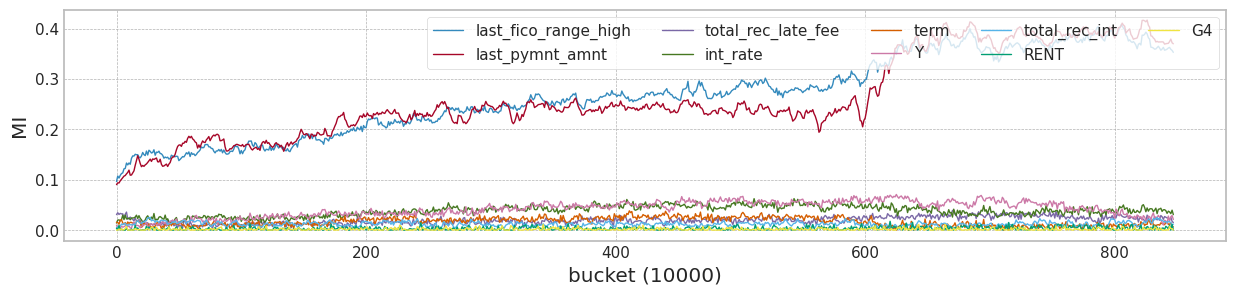

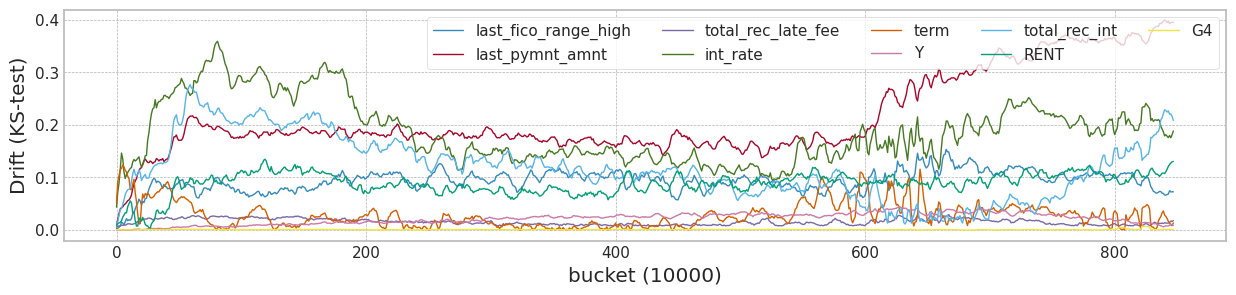

In [111]:
train_size = 10000
test_size = 1497

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

In [112]:
X1['b'] = [int(b/1000) for b in X1.index.values]
X1

,last_fico_range_high,last_pymnt_amnt,total_rec_late_fee,int_rate,term,Y,total_rec_int,RENT,G4,b
0,0.928910,0.032896,0.000000,0.502466,0.0,0.0,0.175629,1.0,0.0,0
1,0.863744,0.010440,0.000000,0.416769,0.0,0.0,0.097918,1.0,0.0,0
2,0.727488,0.381296,0.000000,0.566584,0.0,0.0,0.023318,0.0,0.0,0
3,0.869668,0.021731,0.000000,0.652281,0.0,0.0,0.262327,1.0,0.0,0
4,0.952607,0.027513,0.000000,0.395191,0.0,0.0,0.253892,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
1279675,0.917062,0.000269,0.090128,0.278052,0.0,0.0,0.031754,1.0,0.0,1279
1279676,0.857820,0.403841,0.000000,0.278052,0.0,0.0,0.099365,0.0,0.0,1279
1279677,0.905213,0.334665,0.000000,0.157213,0.0,0.0,0.026058,1.0,0.0,1279
1279678,0.922986,0.971979,0.000000,-0.006165,0.0,0.0,0.085987,0.0,0.0,1279


In [128]:
a = np.asarray([1,2,3,4,5,6])
a[:-1]

array([1, 2, 3, 4, 5])

In [ ]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = np.max(X1['b']))

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 554.20it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9396193393130605
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:02<00:00,  2.80it/s]


mean of drift:
last_fico_range_high    0.117682
last_pymnt_amnt         0.214501
total_rec_late_fee      0.019389
int_rate                0.187503
term                    0.028391
Y                       0.021749
total_rec_int           0.117911
RENT                    0.088541
G4                      0.000962
dtype: float64
Mean F1 for all data: 0.9215728586541053
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [01:19<00:00, 50.57it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9472086355203239
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:55<00:00,  2.87it/s]


mean of drift:
last_fico_range_high    0.998958
last_pymnt_amnt         0.995984
total_rec_late_fee      0.999968
int_rate                1.000000
term                    0.827837
Y                       1.000000
total_rec_int           1.000000
RENT                    1.000000
G4                      1.000000
dtype: float64
Mean F1 for all data: 0.9047429472932462
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [01:19<00:00, 50.57it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9466168349417081
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:55<00:00,  2.87it/s]


mean of drift:
last_fico_range_high    0.924993
last_pymnt_amnt         0.936455
total_rec_late_fee      0.992863
int_rate                0.847284
term                    0.868028
Y                       0.972289
total_rec_int           0.960931
RENT                    0.600917
G4                      0.997073
dtype: float64
Mean F1 for all data: 0.8886243355571112
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [01:20<00:00, 49.67it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9455252918287937
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:55<00:00,  2.87it/s]


mean of drift:
last_fico_range_high    0.905716
last_pymnt_amnt         0.525266
total_rec_late_fee      0.991838
int_rate                0.815597
term                    0.761196
Y                       0.978428
total_rec_int           0.956229
RENT                    0.601600
G4                      0.998400
dtype: float64
Mean F1 for all data: 0.8891612148658131
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [01:20<00:00, 49.66it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9444074567243675
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:56<00:00,  2.86it/s]


mean of drift:
last_fico_range_high    0.903395
last_pymnt_amnt         0.484388
total_rec_late_fee      0.991892
int_rate                0.846310
term                    0.757953
Y                       0.981178
total_rec_int           0.944731
RENT                    0.601214
G4                      0.998400
dtype: float64
Mean F1 for all data: 0.8893762942511887
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [01:22<00:00, 48.51it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9438848920863309
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:56<00:00,  2.86it/s]


mean of drift:
last_fico_range_high    0.816040
last_pymnt_amnt         0.604519
total_rec_late_fee      0.991231
int_rate                0.780541
term                    0.757719
Y                       0.977782
total_rec_int           0.936991
RENT                    0.601332
G4                      0.998400
dtype: float64
Mean F1 for all data: 0.89031210791449
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [01:21<00:00, 49.19it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9433670368528649
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


 78%|███████▊  | 662/848 [03:53<01:06,  2.80it/s]

### Card data 실험

#### Dataset 준비

In [17]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [18]:
!kaggle datasets download "ealtman2019/credit-card-transactions"

 95% 249M/263M [00:02<00:00, 105MB/s]
100% 263M/263M [00:02<00:00, 112MB/s]


In [19]:
!unzip credit-card-transactions.zip

Archive:  credit-card-transactions.zip
  inflating: User0_credit_card_transactions.csv  
  inflating: credit_card_transactions-ibm_v2.csv  
  inflating: sd254_cards.csv         
  inflating: sd254_users.csv         


In [98]:
df = pd.read_csv("credit_card_transactions-ibm_v2.csv")

In [39]:
df['Year'].value_counts()

2019    1723938
2017    1723360
2018    1721615
2016    1708924
2015    1701371
2014    1672343
2013    1650917
2012    1610829
2011    1570551
2010    1491225
2009    1355434
2008    1223460
2007    1064483
2006     908793
2005     746653
2004     597003
2003     466408
2002     350732
2020     336500
2001     257998
2000     177729
1999     118250
1998      78345
1997      49753
1996      29945
1995      20928
1994      14316
1993       8378
1992       5134
1991       1585
Name: Year, dtype: int64

In [40]:
import lightgbm as lgb
from sklearn.metrics import classification_report
df['Is Fraud?']=df['Is Fraud?'].replace({'No':0,'Yes':1})
df1 = df[df['Is Fraud?']==1]
df2 = df[df['Is Fraud?']==0]
df3 = df2.sample(int(df2.shape[0]/30))
df4 = pd.concat([df1,df3])

print("Compression rate:",df4.shape[0] / df.shape[0] )

df = df4

Compression rate: 0.034512832709364456


In [41]:
df['Errors?']=df['Errors?'].fillna('NAN')
df['Errors?']=df['Errors?'].apply(lambda value:value=='NAN')
df['Errors?'].value_counts()

df['Use Chip'].unique()
df['is online']=df['Use Chip'].apply(lambda value:value=='Online Transaction')

from sklearn.preprocessing import LabelEncoder
df['Use Chip']=df['Use Chip'].replace({'Swipe Transaction':0, 'Online Transaction':1, 'Chip Transaction':2})
df['Zip'] = df['Zip'].fillna(df['Zip'].mean())
df['Amount'] = df['Amount'].apply(lambda value: float(value.split("$")[1]))
df['Hour'] = df['Time'].apply(lambda value: int(value.split(":")[0]))
df['Minutes'] = df['Time'].apply(lambda value: int(value.split(":")[1]))
df.drop(['Time'], axis=1, inplace=True)
df['Merchant State']=df['Merchant State'].fillna('NAN')
df['Merchant City']=df['Merchant City'].fillna('NAN')
df['is vozmes']=df['Amount'].apply(lambda value: value<0)
df['abs_amount']=df['Amount'].apply(lambda value: abs(value))

#encoding categorial features
le=LabelEncoder()
df['Merchant State']=le.fit_transform(df['Merchant State'])
le=LabelEncoder()
df['Merchant City']=le.fit_transform(df['Merchant City'])
le=LabelEncoder()
df['Errors?']=le.fit_transform(df['Errors?'])
le=LabelEncoder()
df['is online']=le.fit_transform(df['is online'])
le=LabelEncoder()
df['is vozmes']=le.fit_transform(df['is vozmes'])

df = df.sort_values(['Year','Month','Day'])

df.Year.value_counts()

2016    60412
2015    60116
2018    59563
2019    59488
2017    57276
2013    57029
2014    56782
2012    54838
2010    53127
2011    52594
2009    46612
2008    44566
2007    37404
2006    31560
2005    25216
2004    20436
2003    15753
2002    11773
2020    11251
2001     8820
2000     6049
1999     3969
1998     2689
1997     1641
1996      968
1995      691
1994      511
1993      276
1992      185
1991       66
Name: Year, dtype: int64

In [42]:
drop_columns = ['Is Fraud?','Zip','Year','Month','Day','Minutes','User','Errors?','Merchant Name','Merchant City','Merchant State']
X = df[(df['Year']==2005) |(df['Year']==2006) | (df['Year']==2007) | (df['Year']==2008) | (df['Year']==2009)].drop(drop_columns,axis=1)
y = df[(df['Year']==2005) |(df['Year']==2006) | (df['Year']==2007) | (df['Year']==2008) | (df['Year']==2009)]['Is Fraud?']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185358 entries, 17325692 to 342823
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Card        185358 non-null  int64  
 1   Amount      185358 non-null  float64
 2   Use Chip    185358 non-null  int64  
 3   MCC         185358 non-null  int64  
 4   is online   185358 non-null  int64  
 5   Hour        185358 non-null  int64  
 6   is vozmes   185358 non-null  int64  
 7   abs_amount  185358 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 12.7 MB


In [48]:
np.sum(y[0:30000])

536

#### 실험

MI Analysis MI Max 0.04861, Min 0.00078, Mean 0.01996, Std 0.01460
Dataset structure X_train, (30000, 8) X_test, (30000, 8) X_live (182358, 8)
Truncate 156222 rows from live_set (182358, 8)
Search MI & Drift...for X_live_set (51, 30000, 8)


100%|██████████| 51/51 [00:54<00:00,  1.06s/it]


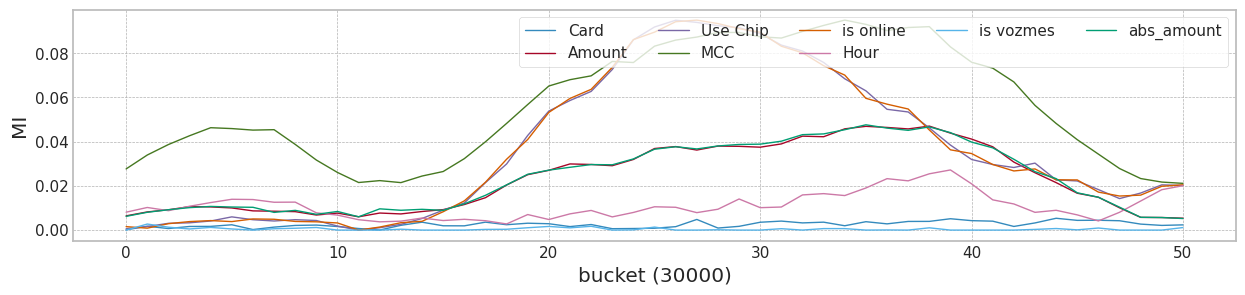

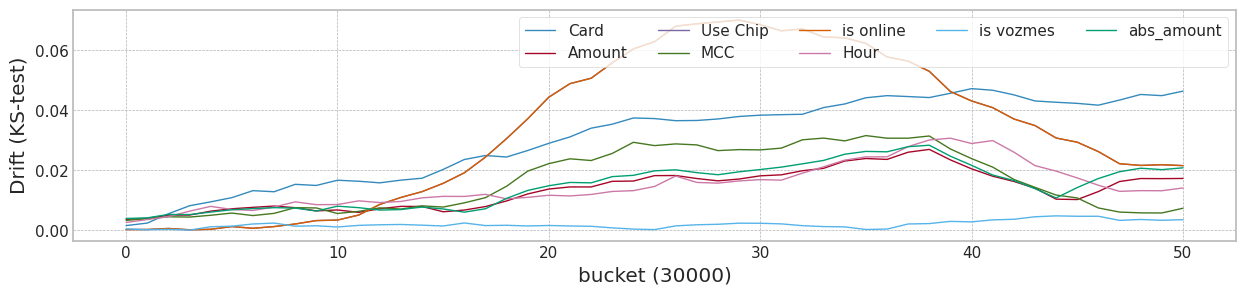

In [49]:

train_size = 30000
test_size = 3000

X1,Y1 = check_mi_drift(X, y.values,train_size, test_size)

MI Analysis MI Max 0.02838, Min 0.00038, Mean 0.00683, Std 0.00866
cuda:0


100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]

MSE: 0.10
RMSE: 0.32


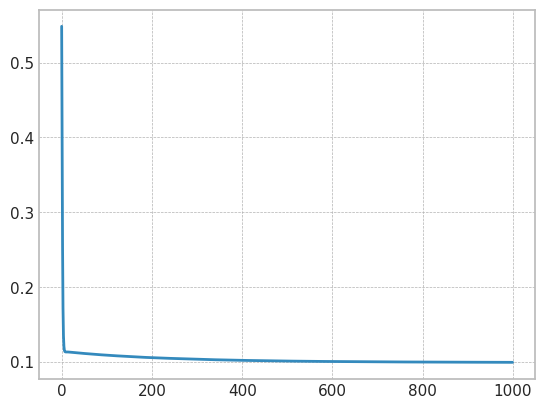

F1 Score:0.00000
Dataset structure X_train, torch.Size([30000, 8]) X_test, torch.Size([30000, 8]) X_live (182358, 8)
Truncate 156222 rows from live_set (182358, 8)


100%|██████████| 51/51 [00:00<00:00, 96.38it/s]


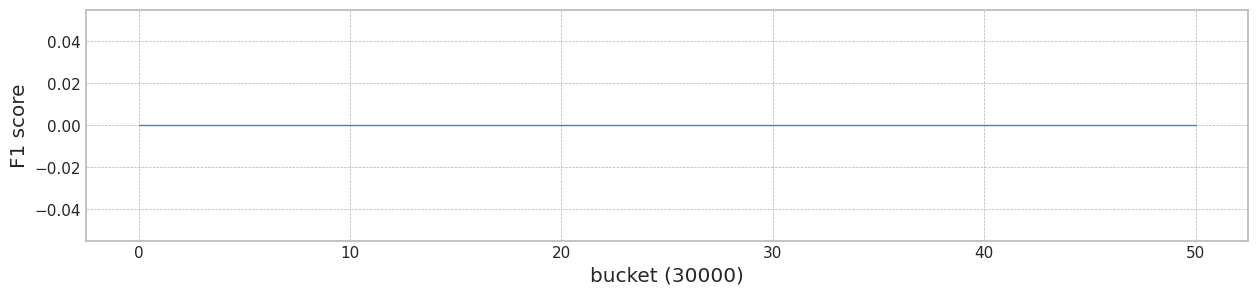

   test_f1  init_f1  mean_f1  last_f1   SUM(MI)
0      0.0      0.0      0.0      0.0  0.054619


In [50]:
model,df = train_classificaion_model(X1,Y1,train_size, test_size)